In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt


In [3]:
from Boosting import runMemlessCifarBoosting

In [4]:
import utils

In [5]:
cuda = torch.device('cuda:0')

In [6]:
%load_ext autoreload
%autoreload 2

## Vanilla PreactResNet

In [37]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=300, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar10_vanilla = WongNeuralNetCIFAR10()
cifar10_vanilla.fit(train_loader, test_loader, alpha = 0, epochs = 1, adv=False, epsilon=0)

In [ ]:
cifar10_vanilla.plot_val_accuracies()

In [ ]:
print(len(cifar10_vanilla.iters), len(cifar10_vanilla.val_accuracies))

## Experiments for CIFAR10 boosting

In [7]:
# maxIt_vals = [10, 20, 30, 50, 100]
# maxIt_vals = [10, 50, 100, 500]
# maxIt_vals = [200, 500]
maxIt_vals = [10]
# default maxIt for weak learner is infinity (i.e. runs each epoch on the entire batch)

In [8]:
num_wl = 100 # maybe around 100? #later: maybe change this to an array?
num_epochs = 1

In [9]:
all_val_accuracies = []
all_train_accuracies_ensemble = []
all_wl = []
all_wl_weights = []

In [ ]:
from pytorch_memlab import LineProfiler
from Boosting import SchapireWongMulticlassBoostingMemoryLess
with LineProfiler(runMemlessCifarBoosting, SchapireWongMulticlassBoostingMemoryLess) as prof:
    for maxIt in maxIt_vals:
        wl, wl_weights, val_accuracies, train_accuracies_ensemble = runMemlessCifarBoosting(num_wl, maxIt, num_epochs)
        all_val_accuracies.append(val_accuracies)
        all_wl.append(wl)
        all_wl_weights.append(wl_weights)
        all_train_accuracies_ensemble.append(train_accuracies_ensemble)
prof.display()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training 0th weak learning
Files already downloaded and verified
adv: False
maxIt: 10


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]


Iteration:  1
memory usage: 143831040


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.10662
Alpha:  0.007355688215338916
After newest WL score is:  0.065
After newest WL training score is:  0.1175
----------------------------------------------------------------------------------------------------
Training 1th weak learning
Files already downloaded and verified
adv: False
maxIt: 10
Iteration:  1
memory usage: 142307328
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.13302
Alpha:  0.036836263046809176
After newest WL score is:  0.155
After newest WL training score is:  0.135
----------------------------------------------------------------------------------------------------
Training 2th weak learning
Files already downloaded and verified
adv: False
maxIt: 10
Iteration:  1
memory usage: 142389248
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.10584
Alpha:  0.007493546750293901
After newest WL score is:  0.155
After newest WL training score is:  0.135
---------------------------------------

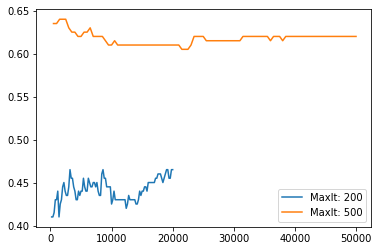

In [13]:
# TODO: plot the accuracies for each usage of maxIt
legend_labels = []
for i in range(len(maxIt_vals)):
    maxIt = maxIt_vals[i]
    val_accuracies = all_val_accuracies[i]
    num_wl = len(all_wl[i])
    plt.plot(np.arange(maxIt, num_wl * maxIt + 1, maxIt), val_accuracies)
    legend_labels.append(f"MaxIt: {maxIt}")
plt.legend(legend_labels)
plt.show()
    

In [14]:
import csv

for i in range(len(maxIt_vals)):
    maxIt = maxIt_vals[i]
    wl = all_wl[i]
    wl_weights = all_wl_weights[i]
    val_accuracies = all_val_accuracies[i]
    wl_file = f"./results/wl_maxIt_{maxIt}.csv"
    wl_weights_file = f"./results/wl_weights_maxIt_{maxIt}.csv"
    val_acc_file = f"./results/val_accuracy_{maxIt}.csv"
    with open(wl_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(wl)
    with open(wl_weights_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(wl_weights)
    with open(val_acc_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(val_accuracies)
    

In [ ]:
# Potential idea: maybe compare wall-clock time b/w CIFAR10 boosting and regular nn training to reach a certain accuracy threshold?

## Compare with other benchmarks? (i.e. other pretrained ensembles?)